In [60]:
%pylab inline
%reload_ext autoreload
%autoreload 2

from __future__ import division
from __future__ import print_function

import os
import copy
import argparse
import fnmatch
import numpy as np

import scipy
from scipy.interpolate import interp1d

# Astropy
from astropy.io import fits
from astropy    import units as u
from astropy.stats import sigma_clip
# AstroML
from astroML.plotting import hist
# Astropy.Table
from astropy.table import Table, Column, MaskedColumn, TableColumns
from astropy.utils.console import ProgressBar

# Matplotlib related
# Matplotlib default settings
rcdef = plt.rcParams.copy()
pylab.rcParams['figure.figsize'] = 12, 10
pylab.rcParams['xtick.major.size'] = 8.0
pylab.rcParams['xtick.major.width'] = 2.5
pylab.rcParams['xtick.minor.size'] = 4.0
pylab.rcParams['xtick.minor.width'] = 2.5
pylab.rcParams['ytick.major.size'] = 8.0
pylab.rcParams['ytick.major.width'] = 2.5
pylab.rcParams['ytick.minor.size'] = 4.0
pylab.rcParams['ytick.minor.width'] = 2.5
pylab.rcParams['legend.numpoints'] = 1

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import MaxNLocator

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [88]:
# Read in the data
del memData
catDir = '/Users/songhuang/work/hscs/gama_compare/redmapper'
catMem = os.path.join(catDir, 'hsc_redmapper_mem_wide15a_2arcsec_match_zUse_flux_cmodel.fits')
memData = Table.read(catMem, format='fits')

In [89]:
# Number of galaxies
len(memData)

7930

In [90]:
# ID of unique clusters
clusters = np.unique(memData['ID_CLUSTER'])

In [91]:
# Isolate those BCGs
bcgs = np.where(memData['OBJID_MEM'] == memData['OBJID_BCG'])
bcgs[0].shape

(265,)

In [92]:
# New columns for the outputs
del memNew 
memNew = copy.deepcopy(memData)
newID = np.chararray(len(memNew), itemsize=20)
newP = (memNew['P_CEN_1']) * 0.0

In [93]:
# Add two new columns for New ID and P_CEN value 
memNew.add_column(Column(name='ID_MEM', data=newID))
memNew.add_column(Column(name='P_CEN_MEM', data=newP))

In [94]:
# Update the P_CEN_MEM
memNew['P_CEN_MEM'][memNew['OBJID_MEM'] == memNew['ID_CEN_2']] = memNew[memNew['OBJID_MEM'] == 
                                                                        memNew['ID_CEN_2']]['P_CEN_2']
memNew['P_CEN_MEM'][memNew['OBJID_MEM'] == memNew['ID_CEN_3']] = memNew[memNew['OBJID_MEM'] == 
                                                                        memNew['ID_CEN_3']]['P_CEN_3']
memNew['P_CEN_MEM'][memNew['OBJID_MEM'] == memNew['ID_CEN_4']] = memNew[memNew['OBJID_MEM'] == 
                                                                        memNew['ID_CEN_4']]['P_CEN_4']
memNew['P_CEN_MEM'][memNew['OBJID_MEM'] == memNew['ID_CEN_5']] = memNew[memNew['OBJID_MEM'] == 
                                                                        memNew['ID_CEN_5']]['P_CEN_5']

In [95]:
np.max(memNew['P_CEN_MEM'])

0.48453107

In [96]:
# Only select the ones with P_MEM >= 0.2 
memGood = memNew[memNew['P_MEM'] > 0.2]
len(memGood)

6515

In [98]:
# Update member ID 
for cc in clusters:
    for ii, index in enumerate(np.where(memGood['ID_CLUSTER'] == cc)[0]):
        memGood['ID_MEM'][index] = str(cc).strip() + '_' + str(ii+1).strip()

In [99]:
# Save the output catalog 
outCat = catMem.replace('.fits', '_new.fits')
memGood.write(outCat, format='fits', overwrite=True)

In [100]:
outCat

'/Users/songhuang/work/hscs/gama_compare/redmapper/hsc_redmapper_mem_wide15a_2arcsec_match_zUse_flux_cmodel_new.fits'

# Deal with the redshift of the BCGs 

In [47]:
catBcg = os.path.join(catDir, 'hsc_redmapper_bcg_wide15a_3arcsec_match_zUse.fits')
bcgData = Table.read(catBcg, format='fits')

In [48]:
# Three redshift related information: Z_LAMBDA, Z_SPEC_BCG, and z_use
for ii, bcg in enumerate(bcgData): 
    if not np.isfinite(bcg['z_use']): 
        """First check Z_SPEC_BCG"""
        if bcg['Z_SPEC_BCG'] > 0.0: 
            bcgData[ii]['z_use'] = bcg['Z_SPEC_BCG']
        else: 
            """If no specZ available, use Z_LAMBDA instead"""
            bcgData[ii]['z_use'] = bcg['Z_LAMBDA']

In [50]:
bcgData.write(catBcg, format='fits', overwrite=True)

In [55]:
np.min(bcgData['z_use'])

0.12397

# Deal with the redshift of the Members

In [64]:
del memData
catMem = os.path.join(catDir, 'hsc_redmapper_mem_wide15a_2arcsec_match_zUse.fits')
memData = Table.read(catMem, format='fits')

In [65]:
memData.add_column(Column(name='z_use_bcg', data=(memData['Z_LAMBDA']*0.0)))

In [66]:
# Three redshift related information: Z_LAMBDA, Z_SPEC_BCG, Z_SPEC_MEM and z_use
with ProgressBar(len(memData), ipython_widget=True) as bar:
    for ii, gal in enumerate(memData): 
        if not np.isfinite(gal['z_use']): 
            """First check Z_SPEC_MEM"""
            if gal['Z_SPEC_MEM'] > 0.0: 
                memData[ii]['z_use'] = gal['Z_SPEC_MEM']
            else: 
                """If no specZ available, use Z_LAMBDA instead"""
                memData[ii]['z_use'] = gal['Z_LAMBDA']
            bar.update()

In [67]:
with ProgressBar(len(memData), ipython_widget=True) as bar:
    for jj, gal in enumerate(memData):
        zCluster = (bcgData[bcgData['ID_CLUSTER'] == gal['ID_CLUSTER']]['z_use'])
        if len(zCluster) > 0: 
            memData[jj]['z_use_bcg'] = zCluster[0]
        elif gal['Z_SPEC_BCG'] > 1E-5: 
            memData[jj]['z_use_bcg'] = gal['Z_SPEC_BCG']
        else: 
            memData[jj]['z_use_bcg'] = gal['Z_LAMBDA']
        bar.update()

In [76]:
memUse = copy.deepcopy(memData)
memUse = memUse[(np.abs(memData['z_use'] - memData['z_use_bcg']) <= 0.08) & 
                ((memData['MODEL_MAG_r_MEM'] - memData['MODEL_MAG_r_BCG']) <= 2.0)]
print("## %d member galaxies remained in the sample" % len(memUse))

## 7930 member galaxies remained in the sample


In [80]:
memUse.write(os.path.join(catDir, 'hsc_redmapper_mem_wide15a_2arcsec_match_zUse.fits'), 
             format='fits', overwrite=True)

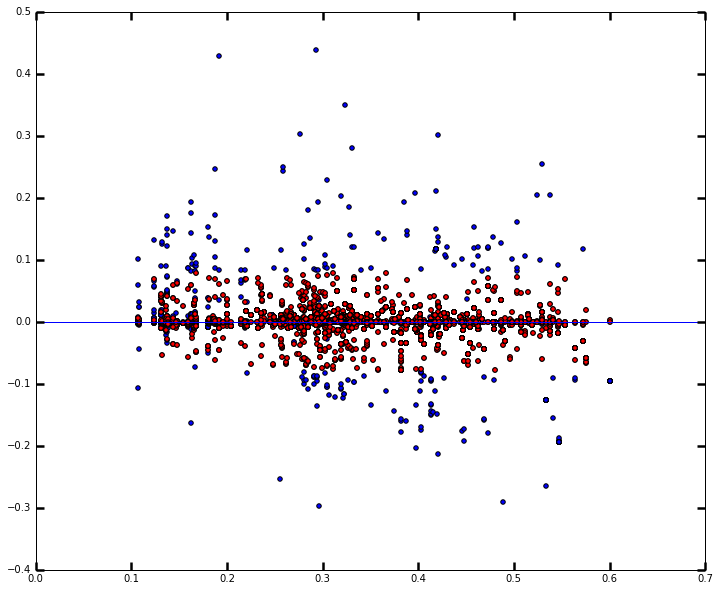

In [78]:
plt.scatter(memData['z_use_bcg'], (memData['z_use'] - memData['z_use_bcg']))
plt.scatter(memUse['z_use_bcg'], (memUse['z_use'] - memUse['z_use_bcg']), c='r')

plt.axhline(0.0)

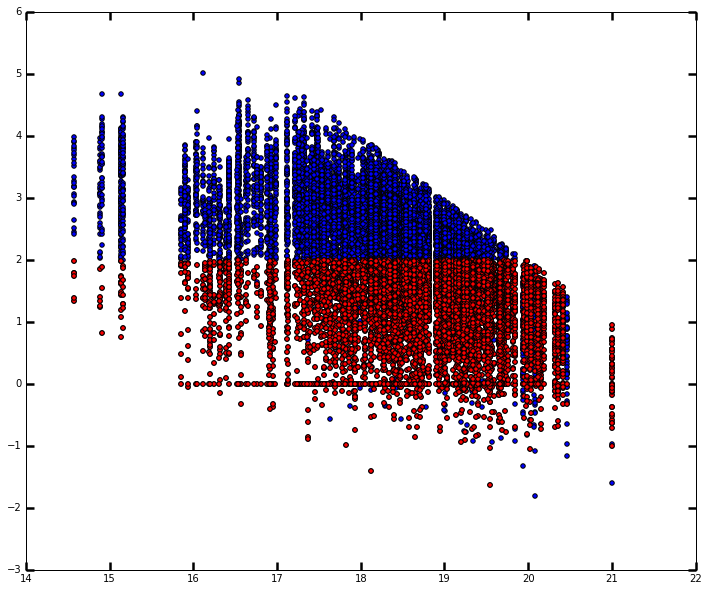

In [79]:
# Filter through the member catalog
plt.scatter(memData['MODEL_MAG_r_BCG'], (memData['MODEL_MAG_r_MEM'] - memData['MODEL_MAG_r_BCG']))
plt.scatter(memUse['MODEL_MAG_r_BCG'], (memUse['MODEL_MAG_r_MEM'] - memUse['MODEL_MAG_r_BCG']), c='r')